In [1]:
from gymnasium import spaces
import pickle
import os
import h5py
from PIL import Image
import numpy as np
import math
import random
import transforms3d
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

2025-01-21 15:19:46.060041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 15:19:46.082509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 15:19:46.087781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 15:19:46.100763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 15:19:47.353422: W tensorflow/comp

In [2]:
# Load the dataset

def load_data(input_dir, load_images=False):
    # Define paths to your pickle files
    image_file = os.path.join(input_dir, 'images.h5')
    laser_file = os.path.join(input_dir, 'lasers.pkl')
    odom_file = os.path.join(input_dir, 'odoms.pkl')
    goal_odom_file = os.path.join(input_dir, 'goal_odoms.pkl')
    velocity_file = os.path.join(input_dir, 'velocities.pkl')
    tf_file = os.path.join(input_dir, 'tfs.pkl')
    
    # Load the pickle files
    with open(laser_file, 'rb') as f:
        lasers_raw = pickle.load(f)
        lasers = []
        for laser in lasers_raw:
            lasers.append([100.0 if math.isnan(x) or math.isinf(x) else x for x in laser])
    with open(odom_file, 'rb') as f:
        current_poses = pickle.load(f)
    with open(goal_odom_file, 'rb') as f:
        goal_poses = pickle.load(f)
    with open(velocity_file, 'rb') as f:
        velocities = pickle.load(f)
    # Split velocities into linear and angular components
    linear_velocities = np.array(velocities)[:, :2]  # Linear velocity (x, y)
    angular_velocities = np.array(velocities)[:, 2]  # Angular velocity (z)
    with open(tf_file, 'rb') as f:
        tfs = pickle.load(f)
    if load_images:
        print('loading images')
        with h5py.File(image_file, 'r') as f:
            image_keys = list(f.keys())
            images = [Image.fromarray(f[key][:]).resize((224, 224)) for key in image_keys]
        print('loaded images')
    else:
        images = [None]*len(lasers)

    combined_data = list(zip(images, lasers, current_poses, goal_poses, linear_velocities, angular_velocities, tfs))
    return  combined_data



In [3]:
import transforms3d

# Function to invert a transformation (translation + rotation)
def invert_transform(translation, rotation):
    # Convert the quaternion to a rotation matrix (3x3)
    rotation_matrix = transforms3d.quaternions.quat2mat([rotation[3], rotation[0], rotation[1], rotation[2]])[:3, :3]
    # Invert the rotation matrix (transpose of a rotation matrix is its inverse)
    rotation_matrix_inv = np.transpose(rotation_matrix)
    
    # Invert the translation (apply the inverse rotation to the negative translation)
    translation_inv = -np.dot(rotation_matrix_inv, [translation[0], translation[1], translation[2]])
    
    # Create the inverse quaternion (negate the vector part, keep the scalar part the same)
    rotation_inv = transforms3d.quaternions.qinverse([rotation[3], rotation[0], rotation[1], rotation[2]])
    return translation_inv, rotation_inv

# Function to apply the transformation (translation + rotation) to a point
def transform_point(translation, rotation, point):
    # Convert the point to a homogeneous vector (x, y, z, 1)
    point_homogeneous = np.array([point[0], point[1], point[2], 1.0])
    
    # Create the translation matrix (4x4)
    translation_matrix = np.identity(4)
    translation_matrix[0, 3] = translation[0]
    translation_matrix[1, 3] = translation[1]
    translation_matrix[2, 3] = translation[2]
    # Create the transformation matrix from translation and rotation
    rotation_matrix = np.identity(4)
    rotation_matrix[:3, :3] = transforms3d.quaternions.quat2mat(rotation)[:3, :3]
    # Combine translation and rotation into a single transformation matrix
    transformation_matrix = np.dot(translation_matrix, rotation_matrix)
    # Apply the transformation to the point
    transformed_point = np.dot(transformation_matrix, point_homogeneous)
    
    
    # Return the transformed point (x, y, z)
    return transformed_point[:3]

# Function to transform a point from odom to base_link frame
def transform_pose_to_base_link(translation, rotation, point_in_odom):
    # Get the inverse of the transformation
    translation_inv, rotation_inv = invert_transform(translation, rotation)
    
    # Convert the point from odom to base_link using the inverted transformation
    point_in_base_link = transform_point(translation_inv, rotation_inv, point_in_odom)
    
    return point_in_base_link

In [7]:

def augment_image(image):
    """Apply data augmentation to an image tensor."""
    image = tf.convert_to_tensor(image, dtype=tf.uint8)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

# def flip_image(image, motion_cmd):
#     image = tf.convert_to_tensor(image, dtype=tf.uint8)
#     image = tf.image.random_flip_left_right(image)
#     motion_cmd = [motion_cmd[0], -motion_cmd[1], -motion_cmd[2]] 
#     return image, motion_cmd
    
def serialize_metadata(dataset_length):
    feature = {
        'metadata': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"metadata"])),
        'length': tf.train.Feature(int64_list=tf.train.Int64List(value=[dataset_length]))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()
    
def serialize_example(laser, next_laser, goal, next_goal, motion_command, reward, image=None, next_image=None):
    if image is not None:
        feature = {
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(image).numpy()])),
            # 'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
            'laser': tf.train.Feature(float_list=tf.train.FloatList(value=laser)),
            'goal': tf.train.Feature(float_list=tf.train.FloatList(value=goal)),
            'next_image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(next_image).numpy()])),
            'next_laser': tf.train.Feature(float_list=tf.train.FloatList(value=next_laser)),
            'next_goal': tf.train.Feature(float_list=tf.train.FloatList(value=next_goal)),
            'motion_command': tf.train.Feature(float_list=tf.train.FloatList(value=motion_command)),
            'reward': tf.train.Feature(float_list=tf.train.FloatList(value=[reward]))
        }
    else:
        feature = {
            'laser': tf.train.Feature(float_list=tf.train.FloatList(value=laser)),
            'goal': tf.train.Feature(float_list=tf.train.FloatList(value=goal)),
            'next_laser': tf.train.Feature(float_list=tf.train.FloatList(value=next_laser)),
            'next_goal': tf.train.Feature(float_list=tf.train.FloatList(value=next_goal)),
            'motion_command': tf.train.Feature(float_list=tf.train.FloatList(value=motion_command)),
            'reward': tf.train.Feature(float_list=tf.train.FloatList(value=[reward]))
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(file_path, lasers, next_lasers, goals, next_goals, motion_commands, images, next_images, rewards, augment_images, flip_images, aug_sampling_probability):
    dataset_length = len(lasers)
    indices = list(range(dataset_length))
    random.shuffle(indices)
    dataset_length_new = dataset_length

    # Temporary storage for data records
    data_records = []

    with tf.io.TFRecordWriter(file_path) as writer:
        # Write placeholder metadata initially
        writer.write(serialize_metadata(dataset_length))

        # Write all data records and perform augmentation if needed
        for i in indices:
            if len(images) != 0:
                example = serialize_example(
                    lasers[i], next_lasers[i], goals[i], next_goals[i], motion_commands[i], rewards[i], images[i], next_images[i]
                )
                data_records.append(example)

                if random.random() <= aug_sampling_probability:
                    if augment_images:
                        augmented_img = augment_image(images[i])
                        augmented_next_img = augment_image(next_images[i])
                        augmented_example = serialize_example(
                            lasers[i], next_lasers[i], goals[i], next_goals[i], motion_commands[i], rewards[i], augmented_img, augmented_next_img
                        )
                        data_records.append(augmented_example)
                        dataset_length_new += 1
            else:
                example = serialize_example(lasers[i], next_lasers[i], goals[i], next_goals[i], motion_commands[i], rewards[i])
                data_records.append(example)

    # Rewrite the file with updated metadata and data
    with tf.io.TFRecordWriter(file_path) as writer:
        # Write the updated metadata
        writer.write(serialize_metadata(dataset_length_new))

        # Write all data records
        for record in data_records:
            writer.write(record)

    print(f"Original dataset length: {dataset_length}")
    print(f"New dataset length after augmentation: {dataset_length_new}")



In [5]:
def compute_reward(laser2, goal_distance, prev_goal_dist, action, action_space):
    """
    Define a reward function based on the robot's state.
    """
    collision_value_threshold = 0.4
    collision_num_threshold = 5 # laser points count
    goal_reach_threshold = 0.4 # m
    # minimize distance to the goal
    reward = -goal_distance*2 
    if prev_goal_dist is not None:
        if goal_distance > prev_goal_dist:
            reward -= 10
        else:
            reward += 10

    condition = (laser2 < collision_value_threshold) & (laser2 > 0.05)
    streak = np.convolve(condition, np.ones(collision_num_threshold), mode = 'valid')
    if np.any(streak==collision_num_threshold)   :
        reward -= 100
    if np.any(action < action_space.low) or np.any(action > action_space.high):
        # Penalty for actions outside the defined action space
        reward -= 10 
    if goal_distance < goal_reach_threshold:  # Goal reached
        reward+=120
    return reward

In [6]:
lasers = []
next_lasers = []
linear_velocities = []
angular_velocities = []
images = []
next_images = []
goals = []
next_goals = []
rewards = []
target_distance = 0.2
forward_goal_thresh = 2.4
sampling_probability = 0.4
aug_sampling_probability = 0.5

action_space = spaces.Box(
    low=np.array([-0.0001, -0.01, -0.1]),  
    high=np.array([0.1, 0.01, 0.1]),
    dtype=np.float32
)

root_folder = r"/work/nselva2s/rnd/robile_data_corr_07112024"
use_images = True
scale_output = False
augment_images = True
flip_images = False

for item in os.listdir(root_folder):
    item_path = os.path.join(root_folder, item)
    if item == 'tfrecords':
        continue
    if os.path.isdir(item_path):
        data = load_data(os.path.join(root_folder, item_path), load_images=use_images)
        print('loaded data')
        for i, (_, _, _, goal_pose1, _, _, _) in enumerate(data):
            prev_goal_dist = None
            count = 0
            for j, (image2, laser2, current_pose2, _, linear_velocity2, angular_velocity2, tf2) in enumerate(data[i:]):   
                if random.random() > sampling_probability:
                    continue
                count = count+1
                
                distance = np.sqrt((goal_pose1[0] - current_pose2[0]) ** 2 + (goal_pose1[1] - current_pose2[1]) ** 2)
                if distance >= target_distance:
                    goal_baselink = transform_pose_to_base_link(tf2[0], tf2[1], goal_pose1)
                    goal_distance = distance
                    goal_angle = math.atan2(goal_baselink[1],goal_baselink[0])
                    if abs(goal_angle) < forward_goal_thresh:
                        goals.append([goal_distance, goal_angle])
                        lasers.append(laser2)
                        if count>0:
                            next_goals.append([goal_distance, goal_angle])
                            next_lasers.append(laser2)
                        if use_images:
                            images.append(image2)
                            next_images.append(image2)
                        linear_velocities.append(linear_velocity2)
                        angular_velocities.append(angular_velocity2)  
                        action = list(linear_velocity2)
                        action.append(angular_velocity2)
                        reward = compute_reward(np.array(laser2), goal_distance, prev_goal_dist, np.array(action), action_space)
                        rewards.append(reward)
                        prev_goal_dist = goal_distance
                else:
                    break

            # del last elem of lists since there will be no next stae
            goals.pop()
            lasers.pop()
            if use_images:
                images.pop()
            linear_velocities.pop()
            angular_velocities.pop()  
            rewards.pop()
            
                
print('get motion commands')
motion_commands = np.concatenate([np.expand_dims(np.array(linear_velocities)[:,0], axis=1), np.expand_dims(np.array(linear_velocities)[:,1], axis=1), np.expand_dims(angular_velocities, axis=1)], axis=1)  # Shape: (1000, 3)
if scale_output:
    scaler = StandardScaler()
    standardized_motion_commands = scaler.fit_transform(motion_commands)
    scaler_minmax = MinMaxScaler(feature_range=(-0.1, 0.1))
    motion_commands = scaler_minmax.fit_transform(standardized_motion_commands)



/home/nselva2s/.local/lib/python3.9/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/nselva2s/.local/lib/python3.9/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
loading images
loaded images
loaded data
get motion commands


In [8]:
tf_file = os.path.join(root_folder, 'tfrecords/corr_07112024_withImages_resized_augmented_Critic.tfrecord')
write_tfrecord(tf_file, lasers, next_lasers, goals, next_goals, motion_commands, images, next_images, rewards, augment_images, flip_images, aug_sampling_probability)

2025-01-21 15:25:43.170060: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Original dataset length: 280382
New dataset length after augmentation: 420699


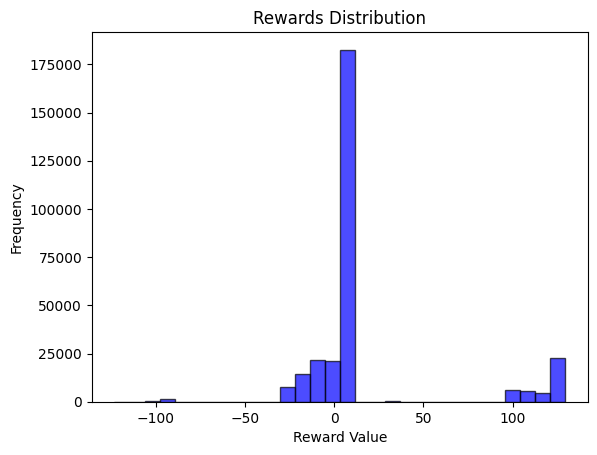

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(rewards, bins=30, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.title('Rewards Distribution')

# Show the plot
plt.show()

In [ ]:
sampled_lasers = []
sampled_images = []
sampled_goals = []
sampled_next_lasers = []
sampled_next_images = []
sampled_next_goals = []
sampled_motion_commands = []
sampled_rewards = []
num_bins = 10  # Number of bins
samples_per_bin = 29000  # Number of samples per bin

x = np.array(rewards)[:,1]
# Create bins based on 'x' values
bins = np.linspace(x.min(), x.max(), num_bins + 1)  # Create bin edges

# Digitize the 'x' values to assign them to bins
bin_indices = np.digitize(x, bins)

# Sample uniformly from each bin
for i in range(1, num_bins + 1):
    # Get indices of data points in the current bin
    indices_in_bin = np.where(bin_indices == i)[0]
    
    if len(indices_in_bin) > 0:
        # Randomly sample from the bin
        sampled_indices = np.random.choice(indices_in_bin, size=min(samples_per_bin, len(indices_in_bin)), replace=True)
        sampled_lasers.extend(np.array(lasers)[sampled_indices])
        sampled_next_lasers.extend(np.array(lasers)[sampled_indices])
        if use_images:
            sampled_images.extend(np.array(images)[sampled_indices])
            sampled_next_images.extend(np.array(next_images)[sampled_indices])
        sampled_goals.extend(np.array(goals)[sampled_indices])
        sampled_next_goals.extend(np.array(next_goals)[sampled_indices])
        sampled_rewards.extend(np.array(rewards)[sampled_indices])
        sampled_motion_commands.extend(np.array(motion_commands)[sampled_indices])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(sampled_rewards, bins=30, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.title('Rewards Distribution after sampling')

# Show the plot
plt.show()

In [9]:

dataset = tf.data.TFRecordDataset(tf_file)
metadata_features = {
    'metadata': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'length': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
}

for record in dataset.take(1):
    print(record)
    parsed_features = tf.io.parse_single_example(record, metadata_features)
    dataset_length = parsed_features['length'].numpy()


tf.Tensor(b'\n-\n\x11\n\x06length\x12\x07\x1a\x05\n\x03\x84\xb3\x1a\n\x18\n\x08metadata\x12\x0c\n\n\n\x08metadata', shape=(), dtype=string)


2025-01-02 18:46:22.346541: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
dataset_length

432516